# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Reply'
PRFX='Reply0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 3.58 s, sys: 376 ms, total: 3.96 s
Wall time: 3.95 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(1850000, 24)


retwt          0.112795
reply          0.027393
like           0.439040
retwt_cmmnt    0.007702
dtype: float64

CPU times: user 14.2 s, sys: 1.43 s, total: 15.6 s
Wall time: 15.6 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.101354
1850000 50677 500000 50677


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
9,101\t137\t48201\t10133\t44026\t10884\t11305\t9...,NaN,24669C0DADEA57A75F6BE24CAC0ACCB9,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1580948734,A6E0653718DB85566D3E6D1E2989AC6D,145,61,False,1522591408,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
11,101\t2341\t7911\t121\t12236\t7596\t7431\t12290...,NaN,E15A666B6A975581F5CE3F2286CDB408,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581344753,74BD974C794C3C2D604E92F9402AB810,318,252,False,1464834037,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
26,101\t144\t87051\t10354\t16874\t196\t10117\t172...,NaN,D8334D0798821B6A99A9C7A4C9E4E3E1,NaN,8FBB6E6890E2ED0F608F83345CB5EA2F,FFA7BC68DEEFEE9FE34F150D60FEA189,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581149159,4CA2E59BBCCB899954E82B01D61C8DF1,16974,612,False,1397475686,06E9CB2FE3EE244FC5D3E2A7E0B7A460,66,512,False,1498734232,False,False,True,False,False
96,101\t11589\t39520\t18487\t58136\t10121\t10911\...,NaN,0C55DCB7494C90953ACE5E70A46B8AA9,NaN,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581470640,58867654CB709C6FBA4F332ED479EF1A,418,554,False,1354395470,06E9F8C1FB619A5AE34B3BE57632DB16,178,339,False,1538938782,True,False,True,True,False
303,101\t65000\t112\t188\t19556\t12172\t10133\t218...,NaN,3058691BBE196B9A3702A8E7584944E9,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580980182,B31DCBBAE66B1E22B1531F77538E88E7,19,440,False,1476507467,06EADF03A34F162DE8051C27C439F6BB,172,167,False,1418024844,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 19:47:50 start
2020-04-11 19:48:00 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 19:48:15 freq of tags
2020-04-11 19:48:20 done
CPU times: user 26.3 s, sys: 3.53 s, total: 29.9 s
Wall time: 29.7 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 19:48:20 start
2020-04-11 19:48:28 freq of columns using CountEncoder
2020-04-11 19:48:40 freq of tags
2020-04-11 19:48:44 done
CPU times: user 21.1 s, sys: 3.12 s, total: 24.2 s
Wall time: 24.1 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 26.3 s, sys: 5.76 s, total: 32 s
Wall time: 32 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
#  'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
33


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270965	vl's binary_logloss: 0.28349
[200]	tr's binary_logloss: 0.264375	vl's binary_logloss: 0.283249
[300]	tr's binary_logloss: 0.259255	vl's binary_logloss: 0.283018
[400]	tr's binary_logloss: 0.254778	vl's binary_logloss: 0.283146
Early stopping, best iteration is:
[313]	tr's binary_logloss: 0.258587	vl's binary_logloss: 0.282942


tune_feature_fraction, val_score: 0.282942:  14%|#4        | 1/7 [00:13<01:17, 12.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270039	vl's binary_logloss: 0.283606
[200]	tr's binary_logloss: 0.263063	vl's binary_logloss: 0.28325
[300]	tr's binary_logloss: 0.257235	vl's binary_logloss: 0.283134
Early stopping, best iteration is:
[270]	tr's binary_logloss: 0.258955	vl's binary_logloss: 0.283045


tune_feature_fraction, val_score: 0.282942:  29%|##8       | 2/7 [00:23<01:00, 12.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268884	vl's binary_logloss: 0.283868
[200]	tr's binary_logloss: 0.261736	vl's binary_logloss: 0.283697
Early stopping, best iteration is:
[186]	tr's binary_logloss: 0.262616	vl's binary_logloss: 0.283631


tune_feature_fraction, val_score: 0.282942:  43%|####2     | 3/7 [00:32<00:44, 11.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268042	vl's binary_logloss: 0.284057
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.268904	vl's binary_logloss: 0.283928


tune_feature_fraction, val_score: 0.282942:  57%|#####7    | 4/7 [00:38<00:29,  9.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266902	vl's binary_logloss: 0.28451
[200]	tr's binary_logloss: 0.25872	vl's binary_logloss: 0.284427
Early stopping, best iteration is:
[160]	tr's binary_logloss: 0.261784	vl's binary_logloss: 0.284362


tune_feature_fraction, val_score: 0.282942:  71%|#######1  | 5/7 [00:47<00:18,  9.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266149	vl's binary_logloss: 0.284835
[200]	tr's binary_logloss: 0.257672	vl's binary_logloss: 0.284971
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.265289	vl's binary_logloss: 0.284725


tune_feature_fraction, val_score: 0.282942:  86%|########5 | 6/7 [00:54<00:08,  8.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26576	vl's binary_logloss: 0.284894
[200]	tr's binary_logloss: 0.257237	vl's binary_logloss: 0.285088
Early stopping, best iteration is:
[134]	tr's binary_logloss: 0.262589	vl's binary_logloss: 0.284841


tune_num_leaves, val_score: 0.282942:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271788	vl's binary_logloss: 0.283523
[200]	tr's binary_logloss: 0.265455	vl's binary_logloss: 0.282988
[300]	tr's binary_logloss: 0.2605	vl's binary_logloss: 0.282763
[400]	tr's binary_logloss: 0.256291	vl's binary_logloss: 0.282766
Early stopping, best iteration is:
[326]	tr's binary_logloss: 0.259416	vl's binary_logloss: 0.282724


tune_num_leaves, val_score: 0.282724:   5%|5         | 1/20 [00:11<03:28, 11.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.237791	vl's binary_logloss: 0.282981
Early stopping, best iteration is:
[82]	tr's binary_logloss: 0.24364	vl's binary_logloss: 0.282886


tune_num_leaves, val_score: 0.282724:  10%|#         | 2/20 [00:21<03:12, 10.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280015	vl's binary_logloss: 0.285443
[200]	tr's binary_logloss: 0.276458	vl's binary_logloss: 0.284237
[300]	tr's binary_logloss: 0.273989	vl's binary_logloss: 0.283541
[400]	tr's binary_logloss: 0.272156	vl's binary_logloss: 0.283304
[500]	tr's binary_logloss: 0.270303	vl's binary_logloss: 0.283222
[600]	tr's binary_logloss: 0.268454	vl's binary_logloss: 0.283063
[700]	tr's binary_logloss: 0.266915	vl's binary_logloss: 0.282945
[800]	tr's binary_logloss: 0.265496	vl's binary_logloss: 0.282924
[900]	tr's binary_logloss: 0.263948	vl's binary_logloss: 0.282882
Early stopping, best iteration is:
[895]	tr's binary_logloss: 0.264041	vl's binary_logloss: 0.282874


tune_num_leaves, val_score: 0.282724:  15%|#5        | 3/20 [00:41<03:53, 13.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.256689	vl's binary_logloss: 0.282832
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.257159	vl's binary_logloss: 0.28278


tune_num_leaves, val_score: 0.282724:  20%|##        | 4/20 [00:49<03:11, 11.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243971	vl's binary_logloss: 0.282962
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.246357	vl's binary_logloss: 0.282826


tune_num_leaves, val_score: 0.282724:  25%|##5       | 5/20 [00:59<02:49, 11.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251872	vl's binary_logloss: 0.283129
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.253926	vl's binary_logloss: 0.283001


tune_num_leaves, val_score: 0.282724:  30%|###       | 6/20 [01:07<02:25, 10.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274849	vl's binary_logloss: 0.283859
[200]	tr's binary_logloss: 0.270032	vl's binary_logloss: 0.283229
[300]	tr's binary_logloss: 0.266334	vl's binary_logloss: 0.283008
[400]	tr's binary_logloss: 0.263105	vl's binary_logloss: 0.282973
[500]	tr's binary_logloss: 0.259995	vl's binary_logloss: 0.282894
Early stopping, best iteration is:
[474]	tr's binary_logloss: 0.26081	vl's binary_logloss: 0.282878


tune_num_leaves, val_score: 0.282724:  35%|###5      | 7/20 [01:21<02:27, 11.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250194	vl's binary_logloss: 0.283138
Early stopping, best iteration is:
[89]	tr's binary_logloss: 0.25256	vl's binary_logloss: 0.282977


tune_num_leaves, val_score: 0.282724:  40%|####      | 8/20 [01:30<02:06, 10.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269523	vl's binary_logloss: 0.28334
[200]	tr's binary_logloss: 0.262328	vl's binary_logloss: 0.283159
[300]	tr's binary_logloss: 0.256553	vl's binary_logloss: 0.283053
Early stopping, best iteration is:
[264]	tr's binary_logloss: 0.258597	vl's binary_logloss: 0.283004


tune_num_leaves, val_score: 0.282724:  45%|####5     | 9/20 [01:40<01:54, 10.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.232261	vl's binary_logloss: 0.283402
Early stopping, best iteration is:
[83]	tr's binary_logloss: 0.238267	vl's binary_logloss: 0.283087


tune_num_leaves, val_score: 0.282724:  50%|#####     | 10/20 [01:51<01:45, 10.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262512	vl's binary_logloss: 0.282852
[200]	tr's binary_logloss: 0.251478	vl's binary_logloss: 0.283003
Early stopping, best iteration is:
[107]	tr's binary_logloss: 0.261576	vl's binary_logloss: 0.282784


tune_num_leaves, val_score: 0.282724:  55%|#####5    | 11/20 [01:58<01:27,  9.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260076	vl's binary_logloss: 0.282593
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.261463	vl's binary_logloss: 0.282522


tune_num_leaves, val_score: 0.282522:  60%|######    | 12/20 [02:05<01:11,  8.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264867	vl's binary_logloss: 0.283092
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.265974	vl's binary_logloss: 0.283037


tune_num_leaves, val_score: 0.282522:  65%|######5   | 13/20 [02:12<00:57,  8.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257952	vl's binary_logloss: 0.282866
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.259607	vl's binary_logloss: 0.282802


tune_num_leaves, val_score: 0.282522:  70%|#######   | 14/20 [02:20<00:48,  8.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.283247	vl's binary_logloss: 0.287007
[200]	tr's binary_logloss: 0.280526	vl's binary_logloss: 0.285624
[300]	tr's binary_logloss: 0.278734	vl's binary_logloss: 0.284859
[400]	tr's binary_logloss: 0.277224	vl's binary_logloss: 0.28449
[500]	tr's binary_logloss: 0.275952	vl's binary_logloss: 0.284136
[600]	tr's binary_logloss: 0.27486	vl's binary_logloss: 0.283949
[700]	tr's binary_logloss: 0.273926	vl's binary_logloss: 0.283775
[800]	tr's binary_logloss: 0.27299	vl's binary_logloss: 0.283595
[900]	tr's binary_logloss: 0.272091	vl's binary_logloss: 0.283445
[1000]	tr's binary_logloss: 0.271176	vl's binary_logloss: 0.283357
[1100]	tr's binary_logloss: 0.27044	vl's binary_logloss: 0.283325
[1200]	tr's binary_logloss: 0.269711	vl's binary_logloss: 0.283209
[1300]	tr's binary_logloss: 0.268959	vl's binary_logloss: 0.283164
[1400]	tr's binary_logloss: 0.268223	vl's binary_logloss: 0.283188
Early stoppin

tune_num_leaves, val_score: 0.282522:  75%|#######5  | 15/20 [02:47<01:08, 13.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265399	vl's binary_logloss: 0.282902
[200]	tr's binary_logloss: 0.256184	vl's binary_logloss: 0.28313
Early stopping, best iteration is:
[106]	tr's binary_logloss: 0.264792	vl's binary_logloss: 0.282849


tune_num_leaves, val_score: 0.282522:  80%|########  | 16/20 [02:54<00:46, 11.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.256746	vl's binary_logloss: 0.282924
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.258386	vl's binary_logloss: 0.282789


tune_num_leaves, val_score: 0.282522:  85%|########5 | 17/20 [03:01<00:31, 10.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249986	vl's binary_logloss: 0.283008
Early stopping, best iteration is:
[82]	tr's binary_logloss: 0.254088	vl's binary_logloss: 0.282888


tune_num_leaves, val_score: 0.282522:  90%|######### | 18/20 [03:10<00:19,  9.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269241	vl's binary_logloss: 0.283531
[200]	tr's binary_logloss: 0.262003	vl's binary_logloss: 0.283394
Early stopping, best iteration is:
[185]	tr's binary_logloss: 0.263024	vl's binary_logloss: 0.283373


tune_num_leaves, val_score: 0.282522:  95%|#########5| 19/20 [03:18<00:09,  9.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260976	vl's binary_logloss: 0.282531
[200]	tr's binary_logloss: 0.249405	vl's binary_logloss: 0.28282
Early stopping, best iteration is:
[103]	tr's binary_logloss: 0.260637	vl's binary_logloss: 0.28249


tune_num_leaves, val_score: 0.282490: 100%|##########| 20/20 [03:26<00:00, 10.31s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26458	vl's binary_logloss: 0.283548
Early stopping, best iteration is:
[82]	tr's binary_logloss: 0.266979	vl's binary_logloss: 0.283462


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  10%|#         | 1/10 [00:07<01:04,  7.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262917	vl's binary_logloss: 0.282905
Early stopping, best iteration is:
[94]	tr's binary_logloss: 0.263827	vl's binary_logloss: 0.282857


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  20%|##        | 2/10 [00:16<01:02,  7.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264032	vl's binary_logloss: 0.283216
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.265234	vl's binary_logloss: 0.283064


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  30%|###       | 3/10 [00:25<00:56,  8.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263387	vl's binary_logloss: 0.283185
Early stopping, best iteration is:
[82]	tr's binary_logloss: 0.266036	vl's binary_logloss: 0.283104


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  40%|####      | 4/10 [00:33<00:49,  8.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263225	vl's binary_logloss: 0.283277
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.26554	vl's binary_logloss: 0.283156


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  50%|#####     | 5/10 [00:42<00:41,  8.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262685	vl's binary_logloss: 0.282687
[200]	tr's binary_logloss: 0.251333	vl's binary_logloss: 0.282934
Early stopping, best iteration is:
[124]	tr's binary_logloss: 0.259577	vl's binary_logloss: 0.282658


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  60%|######    | 6/10 [00:51<00:34,  8.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265191	vl's binary_logloss: 0.283548
[200]	tr's binary_logloss: 0.25369	vl's binary_logloss: 0.28382
Early stopping, best iteration is:
[106]	tr's binary_logloss: 0.264438	vl's binary_logloss: 0.283449


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  70%|#######   | 7/10 [00:59<00:25,  8.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262573	vl's binary_logloss: 0.282704
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.263855	vl's binary_logloss: 0.282606


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  80%|########  | 8/10 [01:07<00:16,  8.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264136	vl's binary_logloss: 0.28317
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.265379	vl's binary_logloss: 0.283051


tune_bagging_fraction_and_bagging_freq, val_score: 0.282490:  90%|######### | 9/10 [01:15<00:08,  8.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_bagging_fraction_and_bagging_freq, val_score: 0.282457: 100%|##########| 10/10 [01:24<00:00,  8.48s/it]
tune_feature_fraction, val_score: 0.282457:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260834	vl's binary_logloss: 0.283016
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261177	vl's binary_logloss: 0.282949


tune_feature_fraction, val_score: 0.282457:  33%|###3      | 1/3 [00:08<00:17,  8.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260421	vl's binary_logloss: 0.282938
Early stopping, best iteration is:
[90]	tr's binary_logloss: 0.262032	vl's binary_logloss: 0.282803


tune_feature_fraction, val_score: 0.282457:  67%|######6   | 2/3 [00:17<00:08,  8.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260177	vl's binary_logloss: 0.283242
[200]	tr's binary_logloss: 0.248665	vl's binary_logloss: 0.283074
[300]	tr's binary_logloss: 0.239593	vl's binary_logloss: 0.283387
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.244569	vl's binary_logloss: 0.282986


tune_feature_fraction, val_score: 0.282457: 100%|##########| 3/3 [00:31<00:00, 10.34s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.282457:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263224	vl's binary_logloss: 0.282662
[200]	tr's binary_logloss: 0.254098	vl's binary_logloss: 0.282729
Early stopping, best iteration is:
[103]	tr's binary_logloss: 0.262931	vl's binary_logloss: 0.282621


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:   5%|5         | 1/20 [00:09<02:58,  9.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261556	vl's binary_logloss: 0.28269
[200]	tr's binary_logloss: 0.250393	vl's binary_logloss: 0.282725
Early stopping, best iteration is:
[106]	tr's binary_logloss: 0.260841	vl's binary_logloss: 0.282606


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:  10%|#         | 2/20 [00:18<02:47,  9.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261411	vl's binary_logloss: 0.282796
Early stopping, best iteration is:
[94]	tr's binary_logloss: 0.262324	vl's binary_logloss: 0.282724


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:  15%|#5        | 3/20 [00:27<02:37,  9.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261454	vl's binary_logloss: 0.282909
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.262803	vl's binary_logloss: 0.28282


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:  20%|##        | 4/20 [00:36<02:24,  9.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:  25%|##5       | 5/20 [00:44<02:13,  8.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261387	vl's binary_logloss: 0.282812
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.26262	vl's binary_logloss: 0.282667


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:  30%|###       | 6/20 [00:53<02:03,  8.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261895	vl's binary_logloss: 0.282731
[200]	tr's binary_logloss: 0.251214	vl's binary_logloss: 0.282636
Early stopping, best iteration is:
[186]	tr's binary_logloss: 0.252468	vl's binary_logloss: 0.282625


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:  35%|###5      | 7/20 [01:05<02:05,  9.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_lambda_l1_and_lambda_l2, val_score: 0.282457:  40%|####      | 8/20 [01:14<01:53,  9.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261413	vl's binary_logloss: 0.282423
[200]	tr's binary_logloss: 0.250037	vl's binary_logloss: 0.282551
Early stopping, best iteration is:
[109]	tr's binary_logloss: 0.260196	vl's binary_logloss: 0.282363


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  45%|####5     | 9/20 [01:23<01:43,  9.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261449	vl's binary_logloss: 0.282672
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.262782	vl's binary_logloss: 0.282618


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  50%|#####     | 10/20 [01:33<01:36,  9.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  55%|#####5    | 11/20 [01:45<01:31, 10.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  60%|######    | 12/20 [01:56<01:24, 10.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  65%|######5   | 13/20 [02:07<01:15, 10.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263135	vl's binary_logloss: 0.28269
[200]	tr's binary_logloss: 0.253281	vl's binary_logloss: 0.282697
Early stopping, best iteration is:
[106]	tr's binary_logloss: 0.262499	vl's binary_logloss: 0.282648


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  70%|#######   | 14/20 [02:21<01:10, 11.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  75%|#######5  | 15/20 [02:33<00:58, 11.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261455	vl's binary_logloss: 0.282506
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261884	vl's binary_logloss: 0.282457


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  80%|########  | 16/20 [02:44<00:46, 11.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261412	vl's binary_logloss: 0.282423
[200]	tr's binary_logloss: 0.250082	vl's binary_logloss: 0.282591
Early stopping, best iteration is:
[109]	tr's binary_logloss: 0.260195	vl's binary_logloss: 0.282363


tune_lambda_l1_and_lambda_l2, val_score: 0.282363:  85%|########5 | 17/20 [02:57<00:35, 11.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261512	vl's binary_logloss: 0.282615
[200]	tr's binary_logloss: 0.250239	vl's binary_logloss: 0.282555
[300]	tr's binary_logloss: 0.241174	vl's binary_logloss: 0.28263
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.246223	vl's binary_logloss: 0.282334


tune_lambda_l1_and_lambda_l2, val_score: 0.282334:  90%|######### | 18/20 [03:12<00:26, 13.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263007	vl's binary_logloss: 0.282539
[200]	tr's binary_logloss: 0.25341	vl's binary_logloss: 0.282508
Early stopping, best iteration is:
[142]	tr's binary_logloss: 0.258414	vl's binary_logloss: 0.282482


tune_lambda_l1_and_lambda_l2, val_score: 0.282334:  95%|#########5| 19/20 [03:23<00:12, 12.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26138	vl's binary_logloss: 0.28293
[200]	tr's binary_logloss: 0.249921	vl's binary_logloss: 0.28302
Early stopping, best iteration is:
[103]	tr's binary_logloss: 0.261033	vl's binary_logloss: 0.282865


tune_lambda_l1_and_lambda_l2, val_score: 0.282334: 100%|##########| 20/20 [03:33<00:00, 10.65s/it]
tune_min_child_samples, val_score: 0.282334:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260451	vl's binary_logloss: 0.283064
Early stopping, best iteration is:
[92]	tr's binary_logloss: 0.261752	vl's binary_logloss: 0.28298


tune_min_child_samples, val_score: 0.282334:  20%|##        | 1/5 [00:08<00:34,  8.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261034	vl's binary_logloss: 0.282882
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.261461	vl's binary_logloss: 0.282846


tune_min_child_samples, val_score: 0.282334:  40%|####      | 2/5 [00:18<00:26,  8.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261678	vl's binary_logloss: 0.282603
[200]	tr's binary_logloss: 0.250582	vl's binary_logloss: 0.282696
Early stopping, best iteration is:
[103]	tr's binary_logloss: 0.26131	vl's binary_logloss: 0.282536


tune_min_child_samples, val_score: 0.282334:  60%|######    | 3/5 [00:27<00:18,  9.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261898	vl's binary_logloss: 0.282436
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.263152	vl's binary_logloss: 0.282391


tune_min_child_samples, val_score: 0.282334:  80%|########  | 4/5 [00:36<00:09,  9.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262445	vl's binary_logloss: 0.282536
[200]	tr's binary_logloss: 0.252242	vl's binary_logloss: 0.282517
[300]	tr's binary_logloss: 0.24418	vl's binary_logloss: 0.28266
Early stopping, best iteration is:
[225]	tr's binary_logloss: 0.250136	vl's binary_logloss: 0.282432


tune_min_child_samples, val_score: 0.282334: 100%|##########| 5/5 [00:51<00:00, 10.32s/it]


CPU times: user 1h 3min 15s, sys: 1h 40min 16s, total: 2h 43min 31s
Wall time: 10min 49s


## best_params

In [20]:
best_params

{'lambda_l1': 1.598055329096984e-08,
 'lambda_l2': 0.0016039352184568367,
 'num_leaves': 73,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.9530250953375053,
 'bagging_freq': 5,
 'min_child_samples': 20}

## tr vl trajec

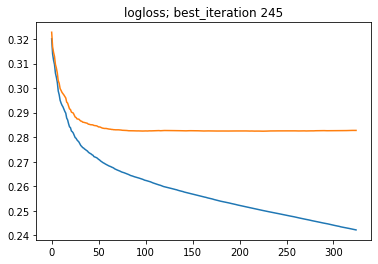

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

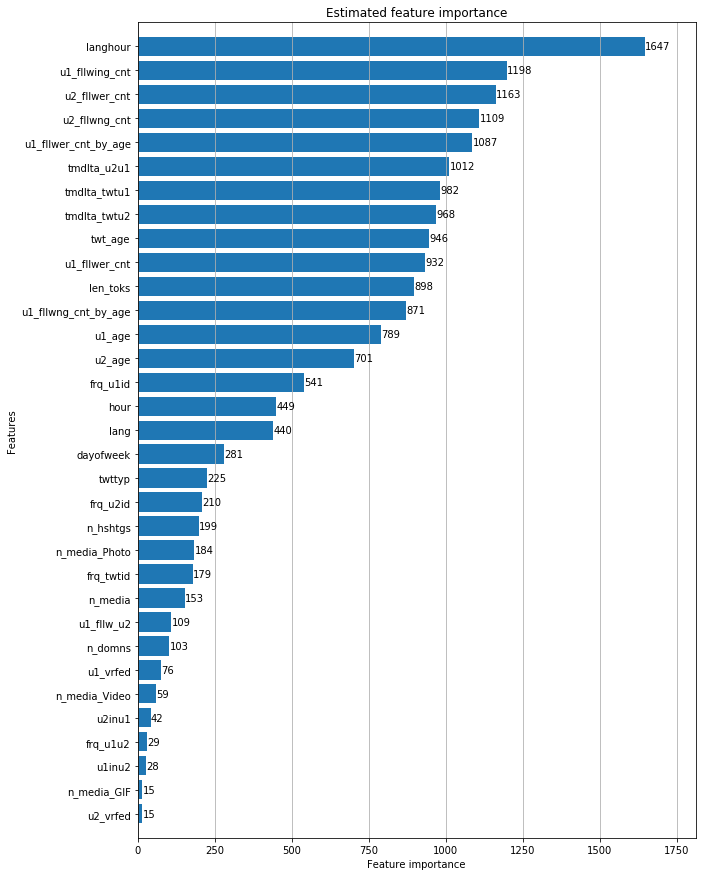

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,1647
3,u1_fllwing_cnt,1198
5,u2_fllwer_cnt,1163
6,u2_fllwng_cnt,1109
26,u1_fllwer_cnt_by_age,1087
20,tmdlta_u2u1,1012
21,tmdlta_twtu1,982
22,tmdlta_twtu2,968
23,twt_age,946
2,u1_fllwer_cnt,932


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 1647),
 ('u1_fllwing_cnt', 1198),
 ('u2_fllwer_cnt', 1163),
 ('u2_fllwng_cnt', 1109),
 ('u1_fllwer_cnt_by_age', 1087),
 ('tmdlta_u2u1', 1012),
 ('tmdlta_twtu1', 982),
 ('tmdlta_twtu2', 968),
 ('twt_age', 946),
 ('u1_fllwer_cnt', 932),
 ('len_toks', 898),
 ('u1_fllwng_cnt_by_age', 871),
 ('u1_age', 789),
 ('u2_age', 701),
 ('frq_u1id', 541),
 ('hour', 449),
 ('lang', 440),
 ('dayofweek', 281),
 ('twttyp', 225),
 ('frq_u2id', 210),
 ('n_hshtgs', 199),
 ('n_media_Photo', 184),
 ('frq_twtid', 179),
 ('n_media', 153),
 ('u1_fllw_u2', 109),
 ('n_domns', 103),
 ('u1_vrfed', 76),
 ('n_media_Video', 59),
 ('u2inu1', 42),
 ('frq_u1u2', 29),
 ('u1inu2', 28),
 ('u2_vrfed', 15),
 ('n_media_GIF', 15)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u1_fllwing_cnt',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u1_fllwer_cnt_by_age',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_fllwer_cnt',
 'len_toks',
 'u1_fllwng_cnt_by_age',
 'u1_age',
 'u2_age',
 'frq_u1id',
 'hour',
 'lang',
 'dayofweek',
 'twttyp',
 'frq_u2id',
 'n_hshtgs',
 'n_media_Photo',
 'frq_twtid',
 'n_media',
 'u1_fllw_u2',
 'n_domns',
 'u1_vrfed',
 'n_media_Video',
 'u2inu1',
 'frq_u1u2',
 'u1inu2',
 'u2_vrfed',
 'n_media_GIF']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 50.7 s, sys: 8.31 s, total: 59.1 s
Wall time: 6.66 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 3.1 s, sys: 243 ms, total: 3.34 s
Wall time: 3.03 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4558
auc_vl:  0.2915
auc_val: 0.0999

rce_tr:  24.8563
rce_vl:  14.4941
rce_val: 11.1693


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0999-11.1693


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 7.96 ms, sys: 0 ns, total: 7.96 ms
Wall time: 6 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 20:00:23 start
2020-04-11 20:00:23 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:00:23 freq of tags
2020-04-11 20:00:23 done
CPU times: user 132 ms, sys: 9.59 ms, total: 142 ms
Wall time: 134 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 19.4 ms, sys: 35.6 ms, total: 54.9 ms
Wall time: 21.9 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)